<파이썬 머신러닝 완벽가이드 개정 2판> 9장 p.601-625
______________________________________________
# CHAPTER 09. 추천 시스템 (Recommendations)
#### 09-05. 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트
   - 장르 속성을 이용한 영화 콘텐츠 기반 필터링
   - 데이터 로딩 및 가공
   - 장르 콘텐츠 유사도 측정
   - 장르 콘텐츠 필터링을 이용한 영화 추천
   
#### 09-06. 아이템 기반 최근접 이웃 협업 필터링 실습
   - 데이터 가공 및 변환
   - 영화 간 유사도 산출
   - 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천
   ___

## 09-05. 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트


### 장르 속성을 이용한 영화 콘텐츠 기반 필터링
- 콘텐츠 기반 필터링 : 상품/서비스 간의 유사성을 판단하는 기준이 그 상품/서비스를 구성하는 다양한 콘텐츠(장르, 감독, 배우, 평점, 키워드, 영화 설명)를 기반으로 함.
- 장르 속성을 이용한 영화 콘텐츠 기반 필터링은
   - 영화를 선택하는데에 중요한 요소 중 하나인 장르 속성을 기반으로
   - 장르 칼럼 값의 유사도를 비교 후
   - 그 중 높은 평점을 가지는 영화를 추천


### (Step 1) 데이터 로딩 및 가공

In [ ]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [ ]:
# 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 새로운 DataFrame 생성
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

In [ ]:
# 칼럼이 어떤 구성으로 되어있는지 확인
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


In [ ]:
# 파이썬 ast 모듈의 literal_eval() 함수를 이용해 문자열을 객체로 변환
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

In [ ]:
# 'name'키에 해당하는 값을 추출하기 위해 apply lambda식 사용
movies_df['genres'] = movies_df['genres'].apply(lambda x : [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


### (Step 2) 장르 콘텐츠 유사도 측정

1. 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환
2. genres 문자열을 피처 벡터화 변환한 데이터 세트를 코사인 유사도로 비교
3. 장르 (코사인) 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천

In [ ]:
# genres 칼럼의 개별 요소를 공백 문자로 구분하는 문자열로 변환해 별도의 칼럼으로 저장
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0.0, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


In [ ]:
# cosine_similarity 함수를 이용해 피처 벡터화. 레코드 4803개 간 유사도를 비교한 결과 4803 * 4803 크기의 벡터.
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


In [ ]:
# genre_sim.argsort()[:, ::1]를 사용하여 높은 순으로 정렬된 비교 행 인덱스 값 추출
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0   46 3494 ... 3331 3333 2031]]


- 0번 레코드의 경우 자신인 0번 레코드를 제외하면 46번 레코드와의 코사인 유사도가 제일 높다는 뜻.

### (Step 3) 장르 콘텐츠 필터링을 이용한 영화 추천
- (문제) 소수의 관객이 특정 영화에 매우 높은 평점을 부여해 평점은 높지만 처음 들어보는 영화, 즉 왜곡된 데이터가 먼저 추출되는 문제가 존재.
- (해결) 평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating)
방식을 사용하여 레코드별 가중 평점을 반환 후 이 평점이 높은 순으로 상위 10개의 영화 추출
- 유명 영화 평점 사이트 IMDB에서 사용하는 Weighted Rating 방식

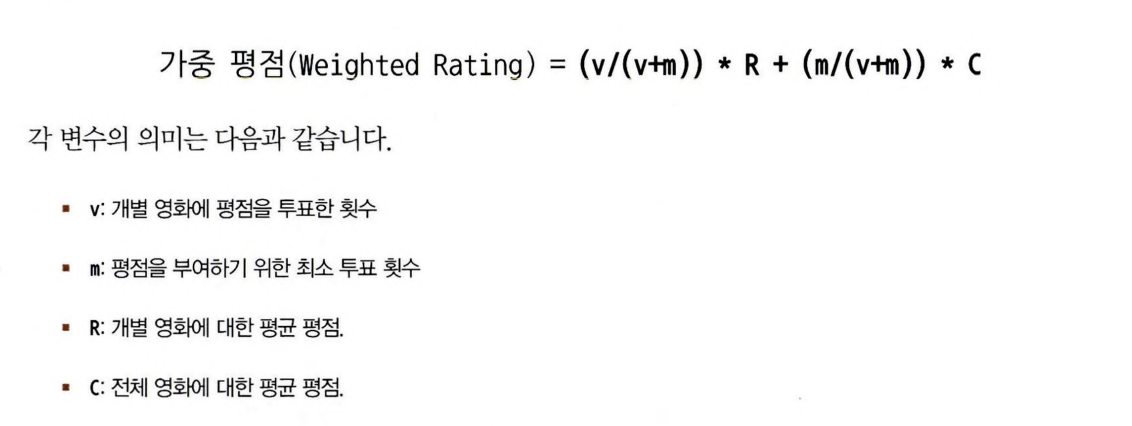

   - m: 평점 투표 횟수가 많은 영화에 더 많은 가중 평점을 부여. 투표 횟수에 따른 가중치를 직접 조절하는 역할.

In [ ]:
# 기반 데이터, 레코드별 장르 코사인 유사도 인덱스, 고객이 선정한 추천 기준인 영화의 제목, 추천할 영화 건수를 입력하면
# 추천 영화 정보를 DataFrame으로 리턴하는 함수 생성

def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name값인 DataFrame 추출
  title_movie = df[df['title'] == title_name]

  # title_name을 가진 DataFrame의 index 객체를 ndarray로 반환하고
  # sort_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력. top_n index는 2차원 데이터임.
  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [ ]:
# 영화 '대부'와 장르별로 유사한 영화 10개 추천
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[1881 3378 3866 1370 1464  588 3887 3594 2839  892]]


,title,vote_average
1881,The Shawshank Redemption,8.5
3378,Auto Focus,6.1
3866,City of God,8.1
1370,21,6.5
1464,Black Water Transit,0.0
588,Wall Street: Money Never Sleeps,5.8
3887,Trainspotting,7.8
3594,Spring Breakers,5.0
2839,Rounders,6.9
892,Casino,7.8


In [ ]:
# 'vote_average' 오름차순으로 movies_df를 정렬해서 10개만 출력
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
4662,Little Big Top,10.0,1
3519,Stiff Upper Lips,10.0,1
4045,"Dancer, Texas Pop. 81",10.0,1
4247,Me You and Five Bucks,10.0,2
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
1881,The Shawshank Redemption,8.5,8205
2970,There Goes My Baby,8.5,2
3337,The Godfather,8.4,5893
2796,The Prisoner of Zenda,8.4,11


In [ ]:
# 가중 평점의 변수 C는 전체 영화의 평균 평점으로, m은 전체 투표 횟수에서 상위 60%에 해당하는 횟수으로 정의
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


In [ ]:
# 가중 평점을 계산하는 함수 생성
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ((v/(v+m)*R) + ((m/(m+v)))*C)

In [ ]:
movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [ ]:
# 새로운 가중 평점 weighted_vote이 높은 순으로 상위 10개의 영화 추출
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [ ]:
# 장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정한 뒤 weighted_vote 칼럼 값이 높은 순으로
# top_n만큼 추출하는 방식으로 find_sim_movie() 함수 변경

def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]


In [ ]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
1881,The Shawshank Redemption,8.5,8.396052
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
3887,Trainspotting,7.8,7.591009
883,Catch Me If You Can,7.7,7.557097
892,Casino,7.8,7.423040
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525


## 09-06. 아이템 기반 최근접 이웃 협업 필터링 실습


### (Step 1) 데이터 가공 및 변환

In [ ]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


- movies.csv는 영화에 대한 정보 title, genres를 가지고 있음.
- ratings.csv는 userId (사용자 아이디), movieId, rating (아이템 간의 평점)을 가짐.

In [ ]:
# 피벗 테이블을 이용해 로우(행) 레벨은 userId, 칼럼 레벨은 movieId 값으로 이름을 바꾸고 데이터는 ratings 값으로 되도록 변경
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### (Step 2) 영화 간 유사도 산출
- 코사인 유사도를 기반으로 영화 (평점) 간 유사도 측정
- (주의) rating_matrix는 행 기준 레이블 데이터가 userId이기 때문에 행에 title이 오도록 transpose 한 후 cosine_similarity 적용해야함.

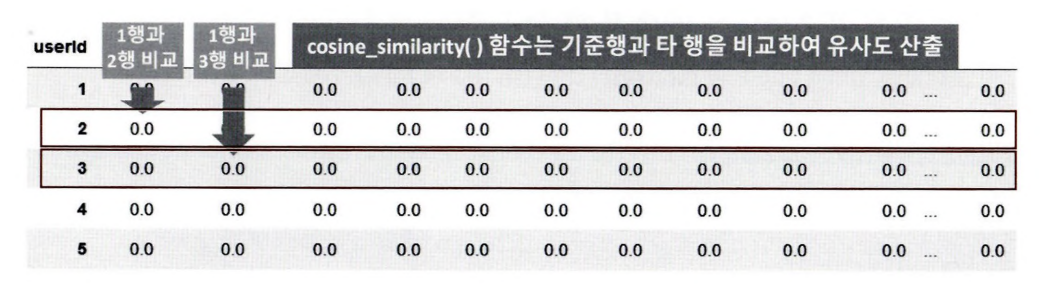

In [ ]:
# 영화 간 코사인 유사도를 추출하기 위해서 행에 영화 이름이, 열에 사용자 아이디가 오도록 함.
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 영화 평점 간 코사인 유사도 추출
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파일 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns, columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [ ]:
# 영화 '대부(Godfather, The (1972))'와 유사도가 높은 상위 6개의 영화를 추출
item_sim_df['Godfather, The (1972)'].sort_values(ascending=False)[:6]

,"Godfather, The (1972)"
title,
"Godfather, The (1972)",1.000000
"Godfather: Part II, The (1974)",0.821773
Goodfellas (1990),0.664841
One Flew Over the Cuckoo's Nest (1975),0.620536
Star Wars: Episode IV - A New Hope (1977),0.595317
Fargo (1996),0.588614


In [ ]:
# 영화 'Inception (2010)'와 유사도가 높은 상위 6개의 영화 추출 (본인 제외)
item_sim_df['Inception (2010)'].sort_values(ascending=False)[1:6]

,Inception (2010)
title,
"Dark Knight, The (2008)",0.727263
Inglourious Basterds (2009),0.646103
Shutter Island (2010),0.617736
"Dark Knight Rises, The (2012)",0.617504
Fight Club (1999),0.615417


### (Step 3) 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천

- 개인이 아직 관람하지 않은 영화에 대해 평점을 예측하여 리턴
- HOW? : 관람하지 않은 영화에 대해서 아이템 유사도와 기존에 관람한 영화의 평점 데이터를 기반으로 새롭게 모든 영화의 예측 평점을 계산
   - 사용자 u, 아이템 i의 개인화된 예측 평점 값 = (사용자 u의 모든 영화에 대한 실제 평점과 영화 i의 다른 모든 영화와의 코사인 유사도의 내적 곱) / (코사인 유사도 벡터 (절댓값)의 합)
      - N : 아이템의 최근접 이웃 범위 계수 (item neighbor)

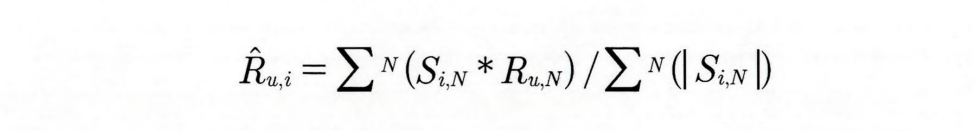

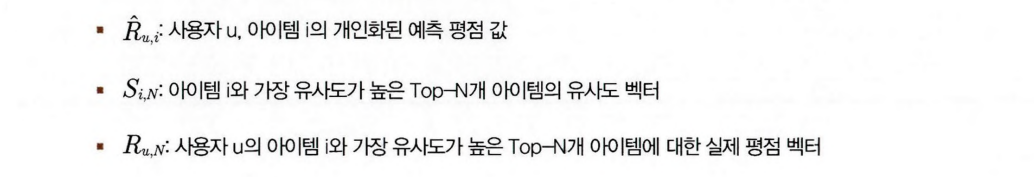

   - 코사인 유사도 벡터 (절댓값)의 합으로 나누었기 때문에 실제 평점보다 더 작은 값으로 예측되었을 가능성

#### 개인화된 예측 평점 계산하는 함수 (1)


In [ ]:
# 개인화된 예측 평점 계산하는 함수
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis=1)])
  return ratings_pred

In [ ]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


In [ ]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함.
def get_mse(pred, actual):
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE: 9.895354759094706


#### 가장 큰 유사도를 가지는 영화 top 20개에 대해서만 유사도 벡터를 적용하는 함수 (2)

In [ ]:
# 가장 큰 유사도를 가지는 영화 top 20개에 대해서만 유사도 벡터를 적용하는 함수로 변환

def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0ㅇ로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행.
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 변환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
    return pred

In [ ]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)

# 예측값과 실제값 간 차이가 많이 줄어듦.
print('아이템 기반 최근접 Top-20 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 최근접 Top-20 이웃 MSE: 3.694409449382562


In [ ]:
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)

In [ ]:
# user id 9번 평점 예측치 높은 순으로 출력
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[user_rating_id > 0].sort_values(ascending=False)[:10]

,9
title,
Adaptation (2002),5.0
Austin Powers in Goldmember (2002),5.0
Back to the Future (1985),5.0
Citizen Kane (1941),5.0
"Lord of the Rings: The Fellowship of the Ring, The (2001)",5.0
"Lord of the Rings: The Two Towers, The (2002)",5.0
"Producers, The (1968)",5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),5.0
Elling (2001),4.0


#### 평점을 주지 않은 영화에 대해서만 예측 평점 내는 함수 (3)

In [ ]:
# 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함.
    # 반환된 user_rating은 영화명(title)을 인덱스를 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId, :]

    #user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦.
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듦.
    movies_list = ratings_matrix.columns.tolist()

    # list comporehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [ ]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
    # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [ ]:
# 사용자 9번이 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                             columns=['pred_score'])

recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591
